# Customer Segmentation with Unsupervised Learning FLO Dataset

# Business Problem

📌 FLO, an online shoe store, wants to segment its customers and determine marketing strategies according to these segments. For this, the behaviors of the customers will be defined and groups will be formed according to the clusters in these behaviors.

# Dataset Story

📌 The dataset consists of information obtained from the past shopping behaviors of customers who made their last purchases on OmniChannel (both online and offline) in 2020 - 2021.

📌 20,000 observations, 13 variables

master_id: Unique client number

order_channel : Which channel of the shopping platform is used (Android, ios, Desktop, Mobile, Offline)

last_order_channel : The channel where the last purchase was made

first_order_date : The date of the first purchase made by the customer

last_order_date : The date of the last purchase made by the customer

last_order_date_online : The date of the last purchase made by the customer on the online platform

last_order_date_offline : The date of the last purchase made by the customer on the offline platform

order_num_total_ever_online : The total number of purchases made by the customer on the online platform

order_num_total_ever_offline : Total number of purchases made by the customer offline

customer_value_total_ever_offline : The total price paid by the customer for offline purchases

customer_value_total_ever_online : The total price paid by the customer for their online shopping

interested_in_categories_12 : List of categories the customer has shopped in the last 12 months

store_type : It represents 3 different companies. If the person who shopped from company A made it from company B, it was written as A, B.

# Import Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime, timedelta
import datetime as dt

pd.set_option("display.max_columns",None)
pd.set_option("display.width",500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

from sklearn.cluster import KMeans
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
from warnings import filterwarnings
filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Dataset

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/flo_data_20k.csv")
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR]


# Setting Date Variables and Create Model DataFrame

In [5]:
def create_model_df(dataframe):
  last_date = dataframe["last_order_date"].max()
  last_date = datetime.strptime(last_date, "%Y-%m-%d")
  last_date = last_date + timedelta(days=1)
  analysis_date = datetime.strftime(last_date, "%Y-%m-%d")
  analysis_date = pd.to_datetime(analysis_date)
  date_columns = dataframe.columns[dataframe.columns.str.contains("date")]
  dataframe[date_columns] = dataframe[date_columns].apply(pd.to_datetime)
  dataframe["recency"] = (analysis_date - dataframe["last_order_date"]).astype('timedelta64[D]')
  dataframe["tenure"] = (dataframe["last_order_date"] - dataframe["first_order_date"]).astype('timedelta64[D]')
  model_df = dataframe[["order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
  return model_df

In [6]:
model_df = create_model_df(df)

In [7]:
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,4.0000,1.0000,139.9900,799.3800,94.0000,119.0000
1,19.0000,2.0000,159.9700,1853.5800,104.0000,1469.0000
2,3.0000,2.0000,189.9700,395.3500,185.0000,366.0000
3,1.0000,1.0000,39.9900,81.9800,134.0000,11.0000
4,1.0000,1.0000,49.9900,159.9900,85.0000,582.0000


# General Information About to the Dataset

In [8]:
def check_df(dataframe,head=5):
  print("######################### Head #########################")
  print(dataframe.head(head))
  print("######################### Tail #########################")
  print(dataframe.tail(head))
  print("######################### Shape #########################")
  print(dataframe.shape)
  print("######################### Types #########################")
  print(dataframe.dtypes)
  print("######################### NA #########################")
  print(dataframe.isnull().sum())
  print("######################### Qurtiles #########################")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [9]:
check_df(model_df)

######################### Head #########################
   order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online  recency    tenure
0                       4.0000                        1.0000                           139.9900                          799.3800  94.0000  119.0000
1                      19.0000                        2.0000                           159.9700                         1853.5800 104.0000 1469.0000
2                       3.0000                        2.0000                           189.9700                          395.3500 185.0000  366.0000
3                       1.0000                        1.0000                            39.9900                           81.9800 134.0000   11.0000
4                       1.0000                        1.0000                            49.9900                          159.9900  85.0000  582.0000
######################### Tail ##################

# Analysis of Variables

In [10]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  #Catgeorical Variable Selection
  cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category","object","bool"]]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8","int64","float64"]]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category","object"]]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  #Numerical Variable Selection
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8","int64","float64"]]
  num_cols = [col for col in num_cols if col not in cat_cols]

  return cat_cols, num_cols, cat_but_car

In [11]:
cat_cols, num_cols, cat_but_car = grab_col_names(model_df)

#Print Categorical and Numerical Variables
print(f"Observations: {model_df.shape[0]}")
print(f"Variables: {model_df.shape[1]}")
print(f"Cat_cols: {len(cat_cols)}")
print(f"Num_cols: {len(num_cols)}")
print(f"Cat_but_car: {len(cat_but_car)}")

Observations: 19945
Variables: 6
Cat_cols: 0
Num_cols: 6
Cat_but_car: 0


In [12]:
def num_summary(dataframe, num_col, plot=False):
  quantiles = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[num_col].describe(quantiles).T)

  if plot:
    dataframe[num_col].hist(bins=20)
    plt.xlabel(num_col)
    plt.title(num_col)
    plt.show(block=True)

In [13]:
def num_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car = grab_col_names(model_df)
  for col in num_cols:
    num_summary(dataframe, col, plot=True)

count   19945.0000
mean        3.1109
std         4.2256
min         1.0000
1%          1.0000
5%          1.0000
10%         1.0000
20%         1.0000
30%         1.0000
40%         1.0000
50%         2.0000
60%         2.0000
70%         3.0000
80%         4.0000
90%         7.0000
95%        10.0000
99%        20.0000
max       200.0000
Name: order_num_total_ever_online, dtype: float64


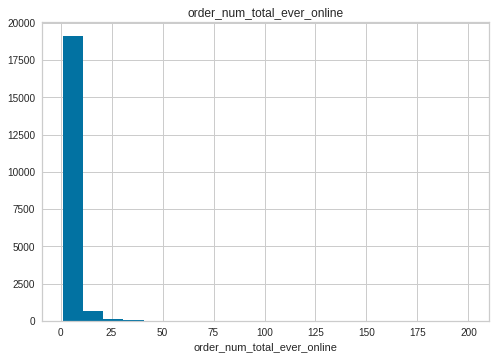

count   19945.0000
mean        1.9139
std         2.0629
min         1.0000
1%          1.0000
5%          1.0000
10%         1.0000
20%         1.0000
30%         1.0000
40%         1.0000
50%         1.0000
60%         2.0000
70%         2.0000
80%         3.0000
90%         4.0000
95%         4.0000
99%         7.0000
max       109.0000
Name: order_num_total_ever_offline, dtype: float64


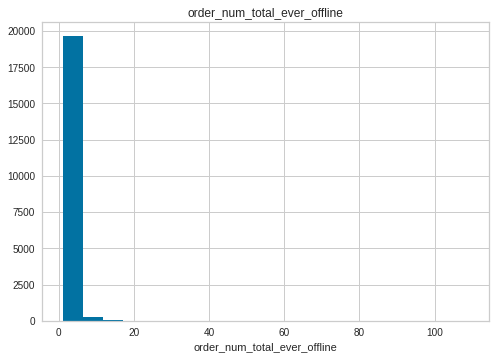

count   19945.0000
mean      253.9226
std       301.5329
min        10.0000
1%         19.9900
5%         39.9900
10%        59.9900
20%        89.9800
30%       110.4800
40%       140.2300
50%       179.9800
60%       220.8600
70%       281.8680
80%       365.0580
90%       519.9500
95%       694.2220
99%      1219.9468
max     18119.1400
Name: customer_value_total_ever_offline, dtype: float64


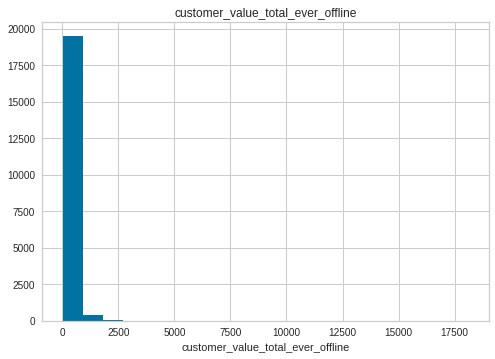

count   19945.0000
mean      497.3217
std       832.6019
min        12.9900
1%         39.9900
5%         63.9900
10%        84.9900
20%       125.9900
30%       173.9700
40%       219.9900
50%       286.4600
60%       371.9440
70%       491.5260
80%       690.8680
90%      1082.0360
95%      1556.7260
99%      3143.8104
max     45220.1300
Name: customer_value_total_ever_online, dtype: float64


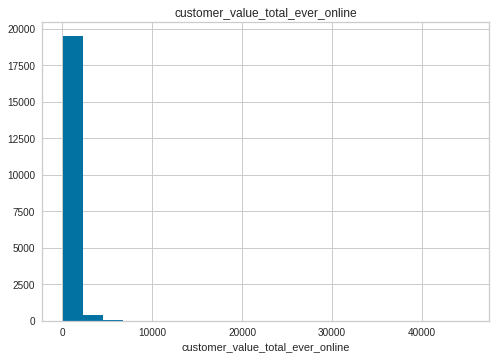

count   19945.0000
mean      133.4584
std       103.2811
min         1.0000
1%          3.0000
5%          8.0000
10%        15.0000
20%        32.0000
30%        55.0000
40%        82.0000
50%       110.0000
60%       144.0000
70%       185.0000
80%       231.0000
90%       307.0000
95%       334.0000
99%       359.0000
max       366.0000
Name: recency, dtype: float64


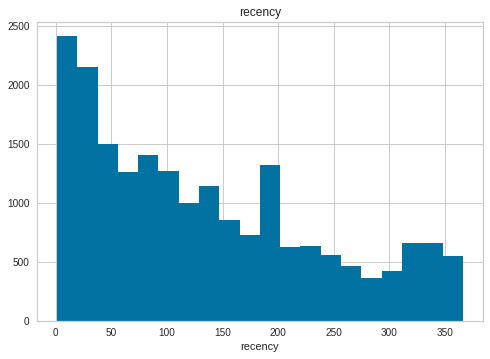

count   19945.0000
mean      666.8445
std       522.1261
min         0.0000
1%         10.0000
5%         88.0000
10%       180.0000
20%       308.0000
30%       396.0000
40%       470.0000
50%       536.0000
60%       607.0000
70%       700.0000
80%       842.0000
90%      1406.6000
95%      1936.8000
99%      2451.5600
max      3034.0000
Name: tenure, dtype: float64


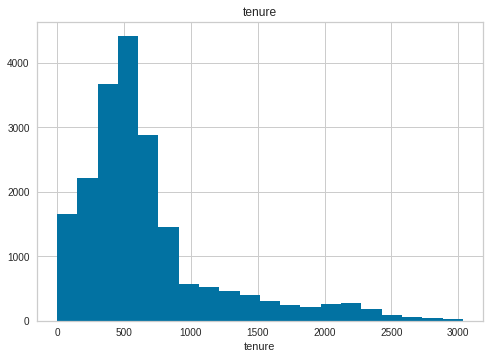

In [14]:
num_summary_df(model_df)

In [15]:
def plot_num_summary(dataframe):
  cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)
  plt.figure(figsize=(12,4))
  for index, col in enumerate(num_cols):
    plt.subplot(2,3,index+1)
    plt.tight_layout()
    dataframe[col].hist(bins=20)
    plt.title(col)

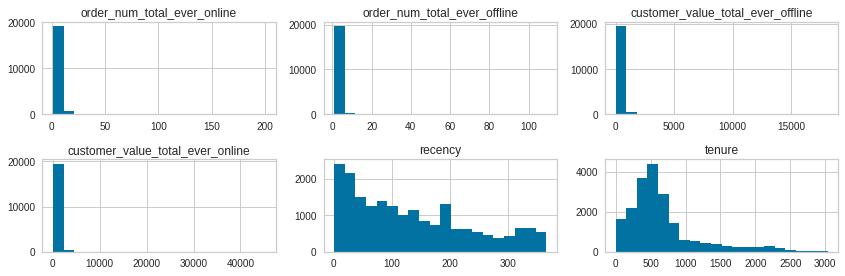

In [16]:
plot_num_summary(model_df)

# Correlation Analysis

In [17]:
model_df.corr()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
order_num_total_ever_online,1.0000,0.0219,0.0030,0.8161,-0.1046,0.3769
order_num_total_ever_offline,0.0219,1.0000,0.6915,0.0112,-0.0454,0.0894
customer_value_total_ever_offline,0.0030,0.6915,1.0000,0.0350,-0.0650,0.0571
customer_value_total_ever_online,0.8161,0.0112,0.0350,1.0000,-0.1073,0.2189
recency,-0.1046,-0.0454,-0.0650,-0.1073,1.0000,-0.0866
tenure,0.3769,0.0894,0.0571,0.2189,-0.0866,1.0000


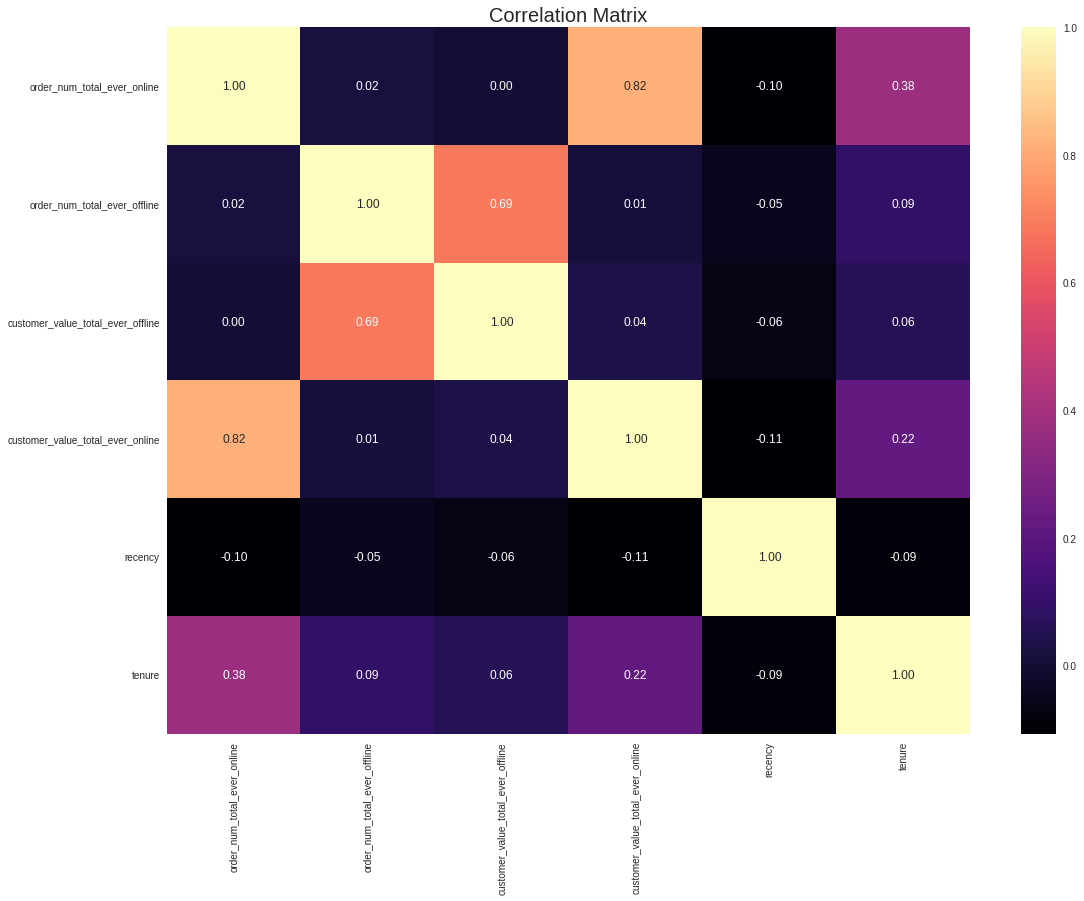

In [18]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(model_df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [19]:
def high_correlated_cols(dataframe, plot=False, corr_th = 0.90):
  corr = dataframe.corr()
  corr_matrix = corr.abs()
  upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
  drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

  if drop_list == []:
    print("############## After Correlation Analysis, You Don't Need to Remove Variables ##############")

  if plot:
    sns.set(rc = {'figure.figsize':(18,13)})
    sns.heatmap(corr, cmap="RdBu")
    plt.show()
  return drop_list

############## After Correlation Analysis, You Don't Need to Remove Variables ##############


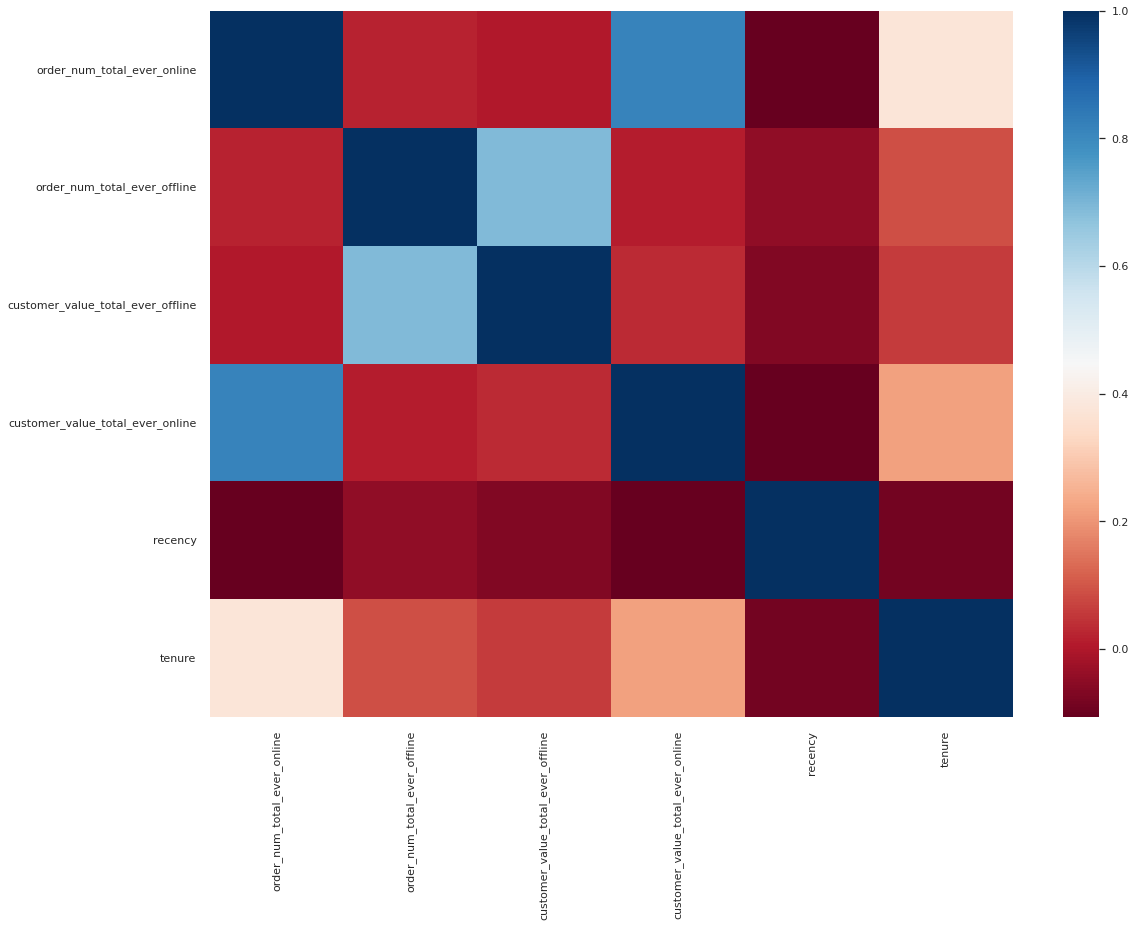

[]

In [20]:
high_correlated_cols(model_df[num_cols], plot=True)

# Exploratory Data Analysis

In [21]:
def exploratory_data(dataframe):
  import warnings
  warnings.filterwarnings('ignore')
  cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)
  fig,ax = plt.subplots(len(num_cols),3,figsize=(20,20))
  for index, col in enumerate(num_cols):
    sns.distplot(dataframe[col],ax=ax[index,0])
    sns.boxplot(dataframe[col],ax=ax[index,1])
    stats.probplot(dataframe[col],plot=ax[index,2])
  fig.tight_layout()
  fig.subplots_adjust(top=0.95)
  plt.suptitle("Visualizing Continuous Columns")

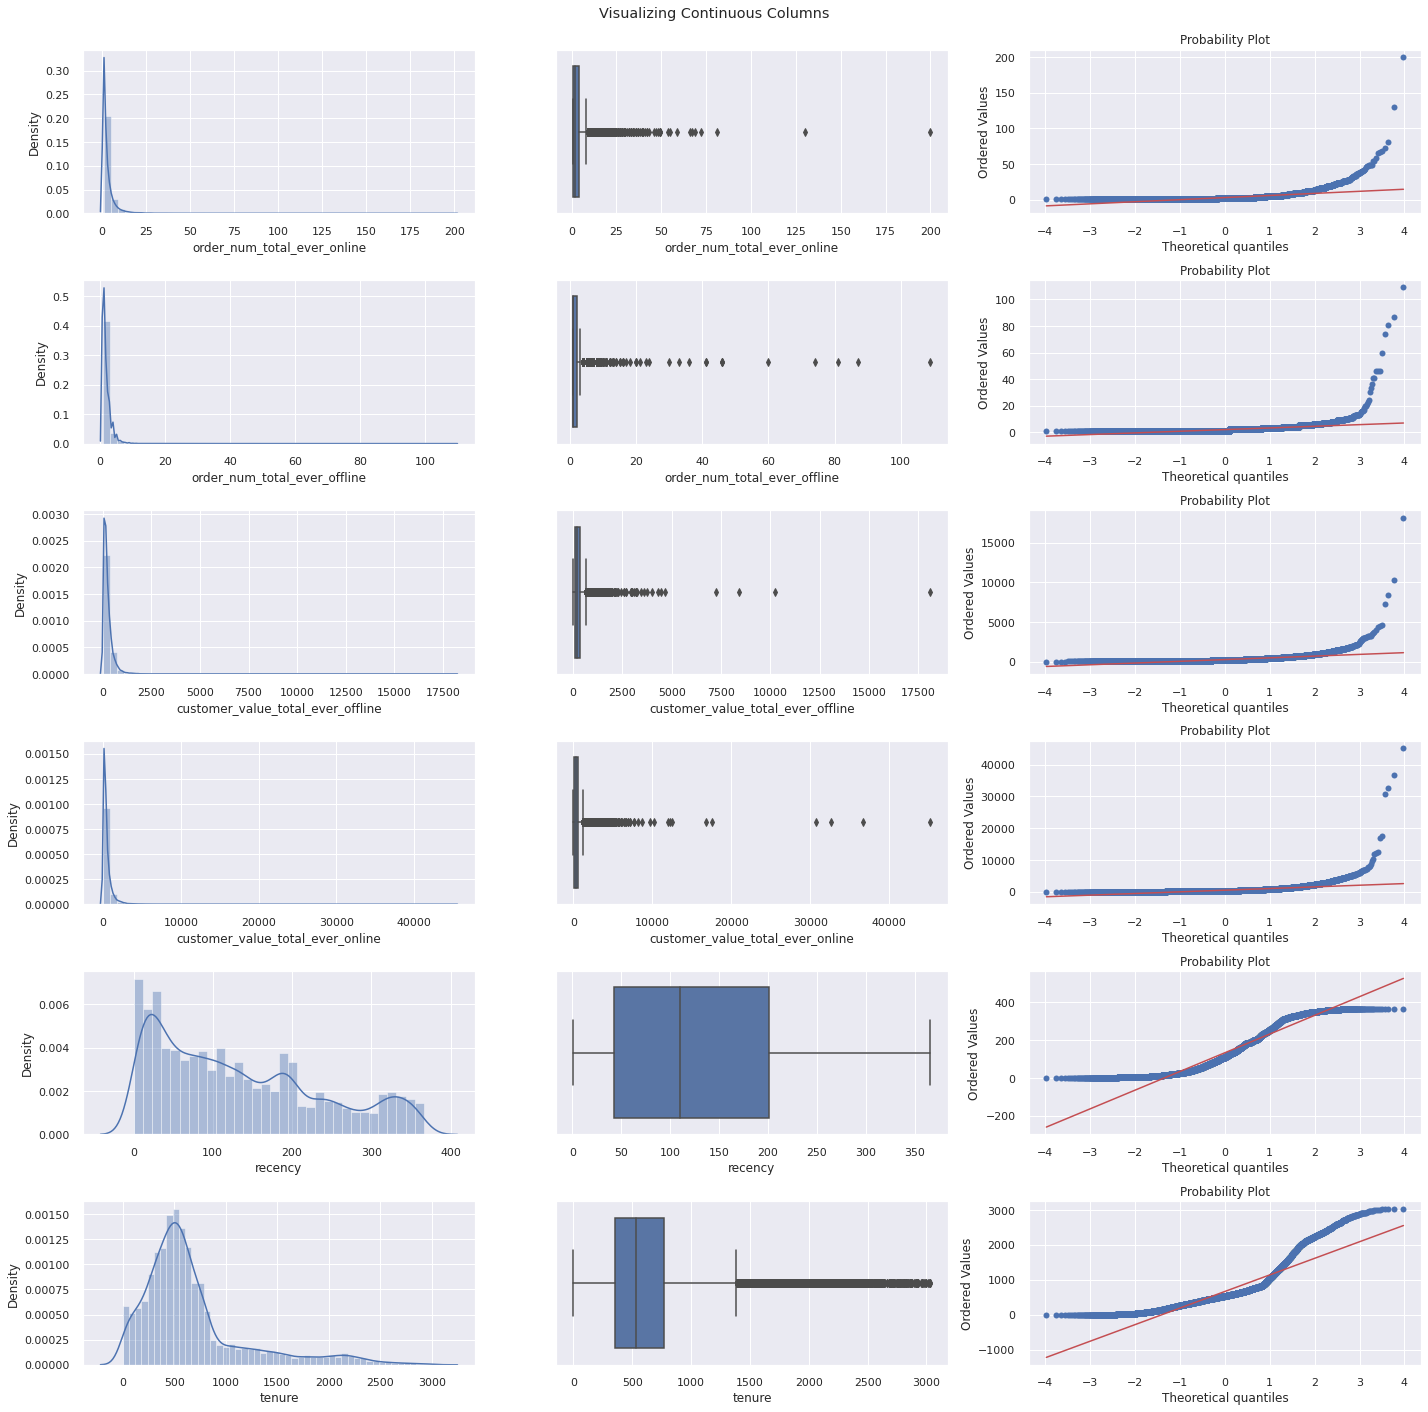

In [22]:
exploratory_data(model_df)

# Skewness Testing

order_num_total_ever_online's ===> Skew: 10.4877, SkewtestResult(statistic=152.9996121784795, pvalue=0.0)

order_num_total_ever_offline's ===> Skew: 20.3281, SkewtestResult(statistic=184.13121810134328, pvalue=0.0)

customer_value_total_ever_offline's ===> Skew: 16.2995, SkewtestResult(statistic=173.73456097827923, pvalue=0.0)

customer_value_total_ever_online's ===> Skew: 20.0843, SkewtestResult(statistic=183.56317267711924, pvalue=0.0)

recency's ===> Skew: 0.6172, SkewtestResult(statistic=32.86977170491703, pvalue=5.944419293752164e-237)

tenure's ===> Skew: 1.7562, SkewtestResult(statistic=71.08790370222574, pvalue=0.0)



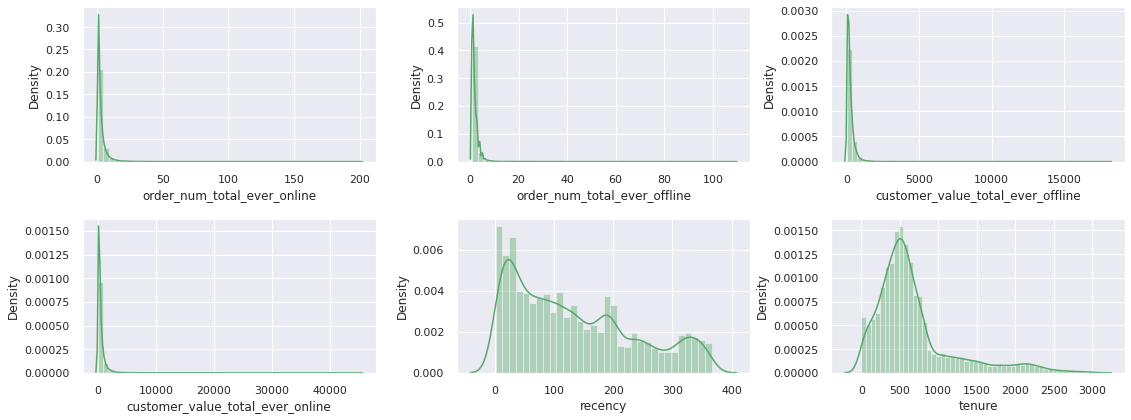

In [23]:
def check_skew(df_skew, column):
  skew = stats.skew(df_skew[column])
  skewtest = stats.skewtest(df_skew[column])
  sns.distplot(df_skew[column], color = "g")
  print("{}'s ===> Skew: {:.4f}, {}\n".format(column, skew, skewtest))
  return

plt.figure(figsize=(16,6))
for index, col in enumerate(num_cols):
  plt.subplot(2,3,index+1)
  plt.tight_layout()
  check_skew(model_df, col)

# Missing Value Analysis

In [24]:
model_df.isnull().sum()

order_num_total_ever_online          0
order_num_total_ever_offline         0
customer_value_total_ever_offline    0
customer_value_total_ever_online     0
recency                              0
tenure                               0
dtype: int64

# Outlier Analysis

In [25]:
def outlier_thresholds(dataframe,col_name,q1=0.10,q3=0.90):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquartile_range = quartile3 - quartile1
  low_limit = quartile1 - 1.5 * interquartile_range
  up_limit = quartile3 + 1.5 * interquartile_range
  return low_limit,up_limit

In [26]:
def check_outlier(dataframe, col_name):
  low_limit,up_limit = outlier_thresholds(dataframe,col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

In [27]:
def replace_with_thresholds(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
  dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

In [28]:
for col in model_df.columns:
  print(col, check_outlier(model_df, col))
  if check_outlier(model_df, col):
    replace_with_thresholds(model_df, col)

order_num_total_ever_online True
order_num_total_ever_offline True
customer_value_total_ever_offline True
customer_value_total_ever_online True
recency False
tenure False


In [29]:
for col in model_df.columns:
  print(col, check_outlier(model_df, col))

order_num_total_ever_online False
order_num_total_ever_offline False
customer_value_total_ever_offline False
customer_value_total_ever_online False
recency False
tenure False


# Encoding Scaling

In [30]:
# Log transformation to ensure normal distribution
def log1p_scaling(dataframe):
  for col in dataframe:
    dataframe[col] = np.log1p(dataframe[col])

In [31]:
log1p_scaling(model_df)
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,1.6094,0.6931,4.9487,6.6851,4.5539,4.7875
1,2.8332,1.0986,5.0812,7.5254,4.6540,7.2930
2,1.3863,1.0986,5.2521,5.9823,5.2257,5.9054
3,0.6931,0.6931,3.7133,4.4186,4.9053,2.4849
4,0.6931,0.6931,3.9316,5.0813,4.4543,6.3682


In [32]:
# MinMaxScaler
sc = MinMaxScaler((0, 1))
model_scaling = sc.fit_transform(model_df)
model_df = pd.DataFrame(model_scaling,columns=model_df.columns)
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.4282,0.0000,0.5426,0.7757,0.7407,0.5971
1,1.0000,0.2602,0.5708,0.9368,0.7599,0.9096
2,0.3239,0.2602,0.6071,0.6410,0.8696,0.7365
3,0.0000,0.0000,0.2798,0.3413,0.8081,0.3099
4,0.0000,0.0000,0.3262,0.4683,0.7216,0.7942


# Customer Segmentation with K-Means

📌 The aim is to categorize the observations according to their similarity to each other.

In [33]:
def K_Means_model(dataframe, max_cluster=20, results=True, save_results=True):
  kmeans_model = KMeans()
  visualizer = KElbowVisualizer(kmeans_model, k=(2, max_cluster))
  visualizer.fit(dataframe)
  visualizer.poof()
  n_clusters = visualizer.elbow_value_
  print("##################### Find Optimum Clusters #####################")
  print("Optimum Clusters: ", n_clusters)

  kmeans_model_tuned = KMeans(n_clusters=n_clusters).fit(dataframe)
  if results:
    print("##################### Number of Clusters #####################")
    print("Number of Clusters: ", kmeans_model_tuned.n_clusters)
    print("##################### Cluster Centers #####################")
    print(kmeans_model_tuned.cluster_centers_)
    print("##################### Cluster Labels #####################")
    print(kmeans_model_tuned.labels_ + 1)
  
  if save_results:
    final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
    final_df["segment"] = kmeans_model_tuned.labels_ + 1
    final_df.to_csv("final_df.csv")

  return final_df
    

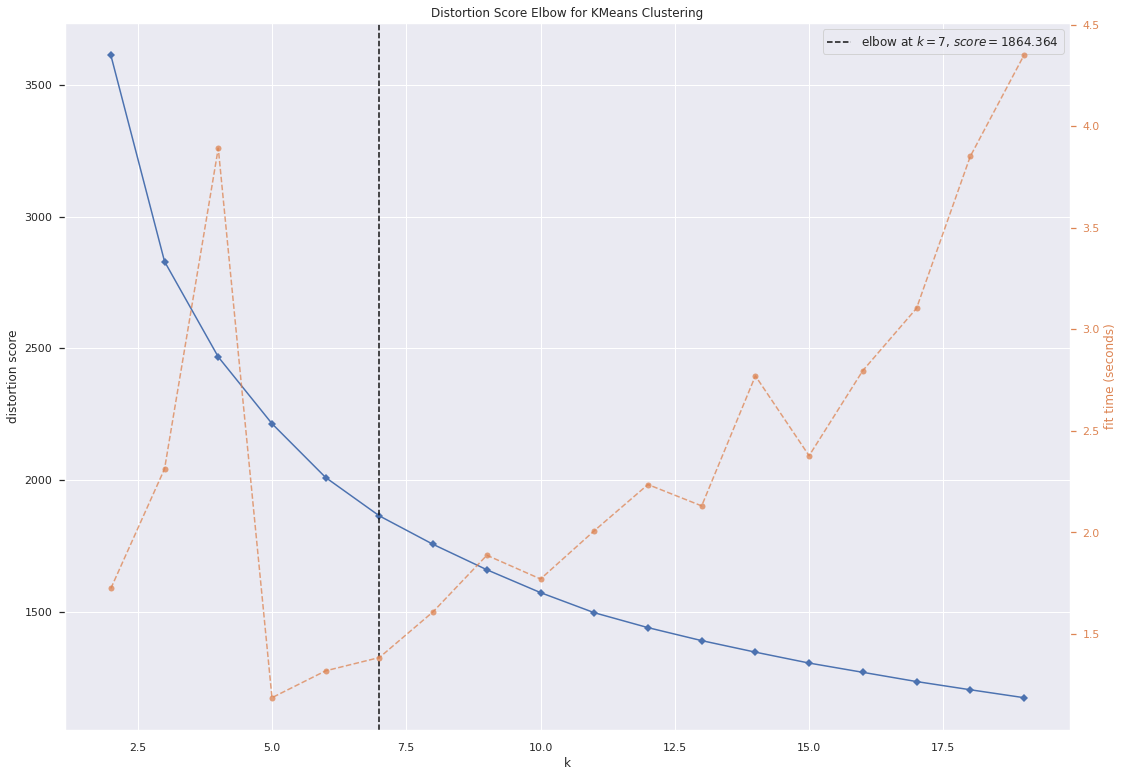

##################### Find Optimum Clusters #####################
Optimum Clusters:  7
##################### Number of Clusters #####################
Number of Clusters:  7
##################### Cluster Centers #####################
[[0.33216019 0.04523094 0.50028436 0.67532271 0.83173769 0.77645429]
 [0.11099573 0.65134132 0.84296647 0.51516999 0.66859687 0.80478325]
 [0.73945054 0.05825901 0.49336154 0.86458405 0.63100547 0.8503396 ]
 [0.06108567 0.31323364 0.68327855 0.4725848  0.82347166 0.77207888]
 [0.02439064 0.00409156 0.48615397 0.43925544 0.83475445 0.69860741]
 [0.13849039 0.09098442 0.55574463 0.55951185 0.38881272 0.75920294]
 [0.56138324 0.45123788 0.75778611 0.7902794  0.66687288 0.83111902]]
##################### Cluster Labels #####################
[1 3 1 ... 6 2 5]


In [34]:
final_df = K_Means_model(model_df)

In [35]:
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                  "order_num_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_online":["mean","min","max"],
                                  "recency":["mean","min","max"],
                                  "tenure":["mean","min","max","count"]})

order_num_total_ever_online                 order_num_total_ever_offline                 customer_value_total_ever_offline                     customer_value_total_ever_online                      recency                     tenure                        
                               mean    min      max                         mean    min      max                              mean      min        max                             mean      min        max     mean     min      max      mean     min       max count
segment                                                                                                                                                                                                                                                                
1                            3.2101 1.0000   8.0000                       1.1742 1.0000   3.0000                          141.1529  10.0000   909.9500                         531.8791  50.0000  4271.4500 178.3074 23.0000 366.0000  665.0907  0.0000 2964.0000  3627
2                            1.6434 1.0000   5.0000                       5.1610 3.0000 109.0000                          698.4416 104.9400 18119.1400                         256.5517  14.9900  2587.2000 100.8496  1.0000 365.0000  728.1387 13.0000 2962.0000  1702
3                           10.5219 4.0000 200.0000                       1.2242 1.0000   3.0000                          140.7935  12.9900  1263.7600                        1657.0310 317.9300 45220.1300  89.9105  1.0000 366.0000 1117.0525 18.0000 3031.0000  1922
4                            1.3339 1.0000   4.0000                       2.2965 1.0000   4.0000                          309.1331  49.9700  1719.9600                         200.4840  14.9900  1219.8400 173.1548 23.0000 366.0000  607.8799  0.0000 2911.0000  3579
5                            1.1289 1.0000   3.0000                       1.0157 1.0000   2.0000                          133.5643  10.4900   829.9800                         163.3998  12.9900  1005.6300 181.0503 22.0000 366.0000  437.1758  0.0000 2697.0000  4454
6                            1.8313 1.0000   7.0000                       1.3626 1.0000   4.0000                          188.4735  12.9900  1406.8500                         323.2980  23.9900  2729.6700  18.2082  1.0000  60.0000  573.5734  0.0000 2928.0000  2733
7                            6.5228 2.0000  72.0000                       3.2728 2.0000  41.0000                          454.7670  64.9700  7247.6000                        1057.8853 185.9600 17599.8900 101.0218  1.0000 363.0000  939.4725  3.0000 3034.0000  1928

# Customer Segmentation with Hierarchical Clustering

📌 The aim is to divide the observations into subsets according to their similarity to each other.

In [36]:
def Hierarchical_Clustering(dataframe, n_clusters, p=10, results=True, save_results=True):
  hc_complete = linkage(dataframe, "complete")
  plt.figure(figsize=(16,10))
  plt.title("Hierarchical Clustering - Dendrogram")
  plt.xlabel("Index")
  plt.ylabel("Distance")
  dendrogram(hc_complete, leaf_font_size=10);
  if p:
    plt.figure(figsize=(16,10))
    plt.title("Hierarchical Clustering - Dendrogram")
    plt.xlabel("Index")
    plt.ylabel("Distance")
    dendrogram(hc_complete, truncate_mode="lastp", p=p, show_contracted=True);
  
  cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="ward")
  cluster_labels = cluster.fit_predict(dataframe)
  if results:
    print("##################### Number of Clusters #####################")
    print("Number of Clusters: ", n_clusters)
    print("##################### Cluster Labels #####################")
    print(cluster_labels + 1)
  
  if save_results:
    final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
    final_df["segment"] = cluster_labels + 1
    final_df.to_csv("final_df.csv")
  
  return final_df

##################### Number of Clusters #####################
Number of Clusters:  7
##################### Cluster Labels #####################
[2 4 2 ... 1 6 5]


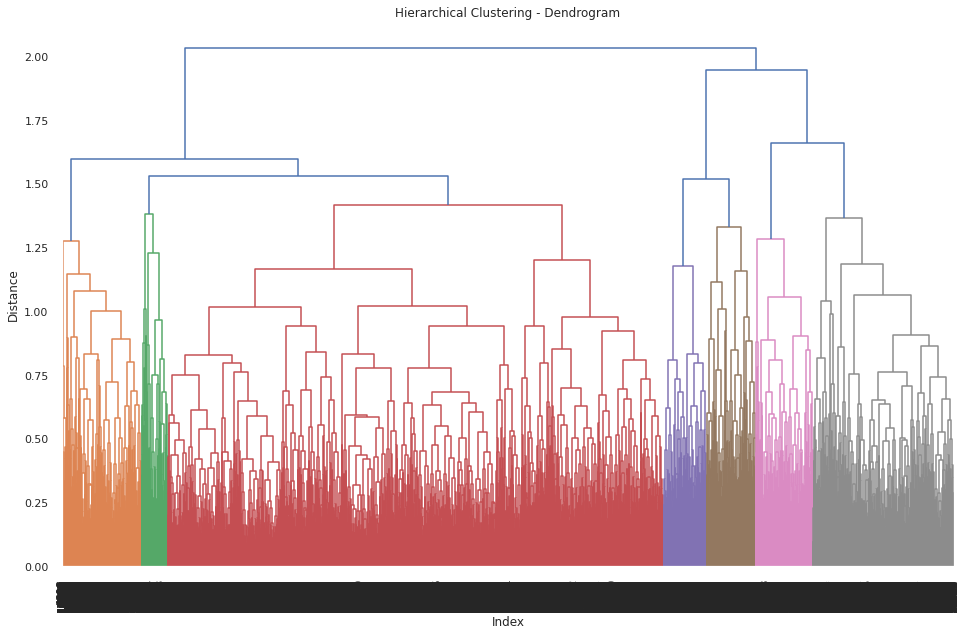

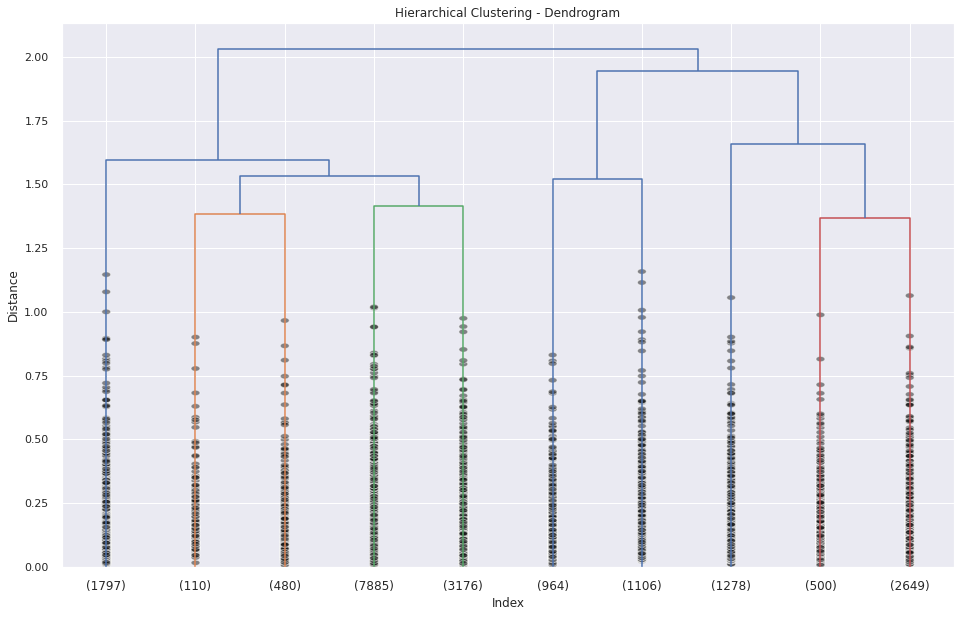

In [37]:
final_df = Hierarchical_Clustering(model_df, n_clusters=7)

In [39]:
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                  "order_num_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_online":["mean","min","max"],
                                  "recency":["mean","min","max"],
                                  "tenure":["mean","min","max","count"]})

order_num_total_ever_online                 order_num_total_ever_offline                 customer_value_total_ever_offline                    customer_value_total_ever_online                      recency                     tenure                        
                               mean    min      max                         mean    min      max                              mean     min        max                             mean      min        max     mean     min      max      mean     min       max count
segment                                                                                                                                                                                                                                                               
1                            1.6336 1.0000   6.0000                       1.4731 1.0000   6.0000                          199.8478 12.9900  1406.8500                         294.1956  19.9900  2729.6700  24.4305  1.0000 125.0000  586.8267 12.0000 2857.0000  2885
2                            2.7974 1.0000   8.0000                       1.3259 1.0000   3.0000                          169.4336 10.0000  1100.6900                         441.8182  39.9800  4271.4500 182.9588 20.0000 366.0000  645.3907  0.0000 2964.0000  4461
3                            7.5898 2.0000 200.0000                       3.3960 1.0000  46.0000                          435.1231 29.9800  7247.6000                        1198.5525 123.1800 45220.1300  86.6320  1.0000 364.0000 1001.6288 24.0000 3034.0000  2182
4                            8.2015 2.0000 130.0000                       1.0210 1.0000   2.0000                          135.8706 12.9900  1049.9200                        1299.0093 215.9700 36687.8000  94.8725  1.0000 366.0000  957.8484 18.0000 3031.0000  2283
5                            1.0257 1.0000   3.0000                       1.0283 1.0000   6.0000                          160.6119 10.4900 18119.1400                         169.9716  12.9900  2587.2000 179.7196  3.0000 366.0000  409.9553  0.0000 2604.0000  3848
6                            1.5506 1.0000   5.0000                       4.2974 2.0000 109.0000                          560.9532 80.4700 10239.4600                         239.3737  14.9900  1181.4400 147.7063  1.0000 365.0000  706.9496 20.0000 2811.0000  2421
7                            1.0016 1.0000   3.0000                       2.0944 2.0000   4.0000                          266.1387 13.9800  1719.9600                         152.7730  14.9900   781.9500 171.7871 20.0000 366.0000  571.9973 27.0000 2750.0000  1865